In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import unet
import keras.backend as K
from helpers import f1
import warnings
import numpy as np
warnings.filterwarnings("ignore")

2025-07-26 18:18:14.624542: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 18:18:14.661392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-26 18:18:14.661431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-26 18:18:14.662784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-26 18:18:14.669329: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model = unet(256, 256, 3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

2025-07-26 18:18:16.564556: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-07-26 18:18:16.564913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4758 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:81:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [3]:
# Images generator (RGB)
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    'data_v3_processed/train/images',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# Masks generator (grayscale, single channel)
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data_v3_processed/train/masks',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

Found 3285 images belonging to 2 classes.
Found 3285 images belonging to 2 classes.


In [4]:
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    'data_v3_processed/val/images',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='rgb',
    seed=42,
    shuffle = False,)

# Masks generator (grayscale, single channel)
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data_v3_processed/val/masks',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='grayscale',
    seed=42,
    shuffle = False,)

Found 109 images belonging to 1 classes.
Found 108 images belonging to 1 classes.


In [5]:
def combine_generator(image_generator, mask_generator):
    while True:
        for img_batch, mask_batch in zip(image_generator, mask_generator):
            yield img_batch, mask_batch

train_generator = combine_generator(train_image_generator, train_mask_generator)
val_generator = combine_generator(val_image_generator, val_mask_generator)

In [6]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=1,
                    steps_per_epoch=3000,
                    validation_steps=13)

2025-07-26 18:18:19.389091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-07-26 18:18:20.289019: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-07-26 18:18:21.901345: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f229077d450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-26 18:18:21.901377: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-07-26 18:18:21.906538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753553902.025571  181739 device_compiler.h:186] Compiled cluster using 

3000/3000 [==============================] - 63s 18ms/step - loss: 0.0067 - f1: 0.7250 - val_loss: 0.0114 - val_f1: 0.7459


In [7]:
import cv2
import numpy as np

img = cv2.imread('data_v3_processed/test/images/images/28_05_08_11.png')
mask = cv2.imread('data_v3_processed/test/masks/masks/28_05_08_11.tif')

img_np = np.array(img)
img_np = np.expand_dims(img_np, axis=0)
img_np = img_np / 255

pred = model.predict(img_np)

1/1 [==============================] - 0s 478ms/step


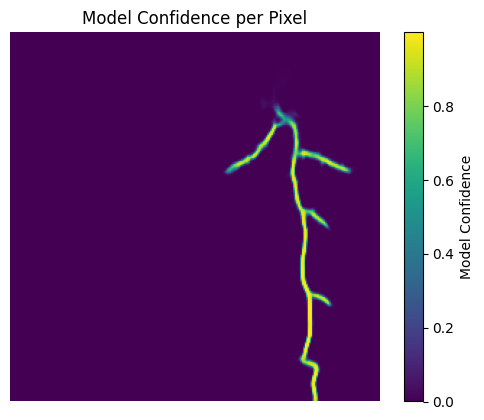

In [8]:
import matplotlib.pyplot as plt

confidence_map = pred[0, :, :, 0]  # Remove batch and channel dims

plt.imshow(confidence_map, cmap='viridis')
plt.colorbar(label="Model Confidence")
plt.title("Model Confidence per Pixel")
plt.axis('off')
plt.show()

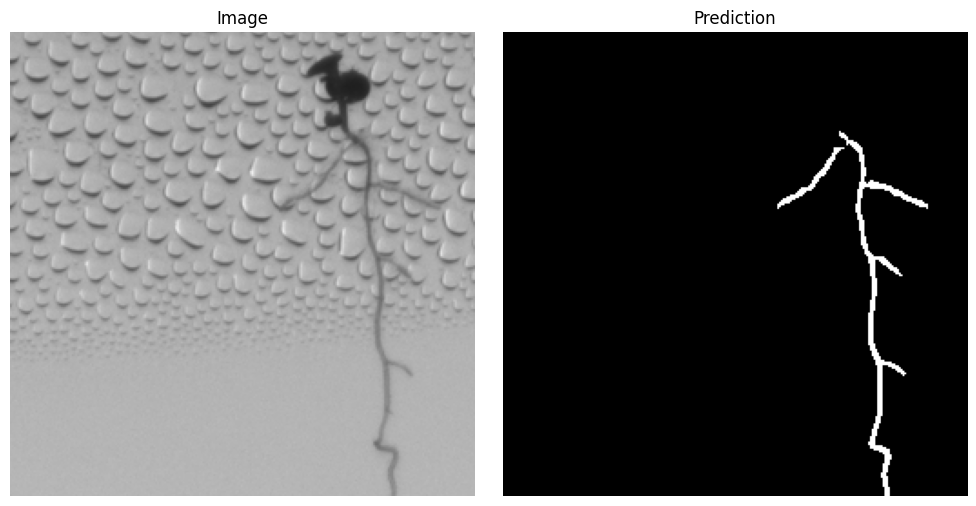

In [9]:
pred = (pred > 0.5).astype(np.uint8)

pred_img = np.squeeze(pred, axis=0)
pred_vis = (pred_img * 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # width x height in inches

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
model.save("unet_model.h5")